In [1]:
import sys
import os
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import fnmatch
from scipy.integrate import quad
import pickle 

import iminuit
from iminuit import Minuit

In [2]:
%load_ext autoreload

%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_DATAOPS_make_MetaCatalog_test as metacat
import CL_WL_DATAOPS_make_binned_profile as prf

from scipy import interpolate
import glob

In [3]:
################################################################################################
Richness_bin, Mass_bin, Z_bin = [[30,32]], [[1.0*1e14, 1.2*1e14]], [[0.2,0.5]]

################################################################################################

where_catalogs = '/sps/lsst/users/cpayerne/dc2_object_run2.2i_dr6_wfd_20_Mpc/all_11_Mpc/'
where_catalogs = '/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/GalaxyClusterCatalogs/test_for_metacal/'
where_catalogs = '/sps/lsst/users/cpayerne/RedMapper_clusters/dc2_object_run2.2i_dr6_wfd_20_Mpc/all_11_Mpc/'

In [4]:
def load(filename, **kwargs):
    
    """Loads GalaxyCluster object to filename using Pickle"""
    
    with open(filename, 'rb') as fin:
        
        return pickle.load(fin, **kwargs)
infos_dc2_cut = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/RedMapper_galaxy_clusters.pkl')
#file_study = glob.glob('/sps/lsst/users/cpayerne/dc2_object_run2.2i_dr6_wfd/dc2_object_run2.2i_dr6_wfd_HSM_Metacal/cluster_ID_*')
#selected_halo_id = np.array([int(file.split("ID_")[1].split('.pkl')[0]) for file in file_study])
#infos_dc2_cut = infos_dc2_cut[np.isin(infos_dc2_cut['halo_id'],selected_halo_id)]

## Defining Stacked cluster catalog

In [5]:
Binning_your_data = Richness_bin
z_bin, obs_bin = Z_bin[0], Binning_your_data[0]
cat = metacat.MetaCatalog(cosmo = cosmo)

In [6]:
try : 
                                       
    cat._check_available_catalogs(dc2_infos = infos_dc2_cut, redshift_def ='redshift', obs_def = 'richness',
                                    z_bin = z_bin, 
                                    obs_bin = obs_bin, 
                                    cluster_name = 'cluster_id',
                                    cluster_key = 'cluster_id_RedMapper_',
                                    where_source = where_catalogs)
except ValueError: 
    
    print('impossible')

2986


In [11]:
len(cat.file_in_bin)

57

In [7]:
column_to_extract = ['dc2_object_id', 'et', 'ex', 'halo_id','<sigma_c-1>_v1', 'mcal_g1', 'mcal_g2', 'R_T', 'e1_HSM', 'e2_HSM', 'mcal_s2n_1p', 'mcal_s2n_1m', 'mcal_s2n_2p', 'mcal_s2n_2m', 'e_sigma_HSM']

In [8]:
def quantity_modifier(cl):
    
    delta_gamma = 0.02
    
    #cl.galcat['mcal_g_err'] = np.sqrt(cl.galcat['mcal_g1_err']**2 + cl.galcat['mcal_g2_err']**2)
    cl.galcat['phi'] = (cl.galcat['dec'] - cl.dec)/((cl.galcat['ra'] - cl.ra)*np.cos(cl.dec*np.pi/180.))
    cl.galcat['R_11'] = (cl.galcat['mcal_g1_1p'] - cl.galcat['mcal_g1_1m']) / delta_gamma
    cl.galcat['R_12'] = (cl.galcat['mcal_g1_2p'] - cl.galcat['mcal_g1_2m']) / delta_gamma
    cl.galcat['R_21'] = (cl.galcat['mcal_g2_1p'] - cl.galcat['mcal_g2_1m']) / delta_gamma
    cl.galcat['R_22'] = (cl.galcat['mcal_g2_2p'] - cl.galcat['mcal_g2_2m']) / delta_gamma
    cl.galcat['R_T'] = cl.galcat['R_11']*np.cos(2*cl.galcat['phi'])**2 + \
                        cl.galcat['R_22']*np.sin(2*cl.galcat['phi'])**2 + \
                        (cl.galcat['R_12'] + cl.galcat['R_21'])*np.sin(2*cl.galcat['phi'])*np.cos(2*cl.galcat['phi'])
    
    cl.galcat['mcal_g1'] = - cl.galcat['mcal_g1']
    cl.galcat['mcal_g2'] = - cl.galcat['mcal_g2']
    
    return cl

In [9]:
cat.make_GalaxyCluster_catalog(z_gal_name = 'z_mean_photoz_v1', 
                               shape_component1_in = 'mcal_g1', 
                               shape_component2_in = 'mcal_g2', 
                               tan_component_out = 'et', 
                               cross_component_out = 'ex',
                               column_to_extract = column_to_extract, 
                               rmax = 11,
                               modify_quantity = True, 
                               quantity_modifier = quantity_modifier)
cl_Metacal = cat.cl

In [10]:
cl_Metacal = cat.compute_signal(sigma_c_1_in = '<sigma_c-1>_v1',tan_in = 'et', cross_in = 'ex', tan_out = 'st', cross_out = 'sx', catalog = cl_Metacal)
cl_Metacal = cat.compute_weights(err_shape_in = None,  sigma_c_1_in = '<sigma_c-1>_v1', weight_out = 'w_ls',  catalog = cl_Metacal)

In [11]:
bin_edges1 = make_bins(1, 10, nbins=10, method = 'evenlog10width')
shear = prf.Shear(is_deltasigma = True, cosmo = cosmo)
col_to_bin = ['w_ls','halo_id','dc2_object_id', 'et', 'ex','st', 'sx', 'R_T', 'mcal_s2n_1p', 'mcal_s2n_1m', 'mcal_s2n_2p', 'mcal_s2n_2m', 'mcal_g1', 'mcal_g2']

profile_Metacal = shear.make_binned_profile(metacatalog = cl_Metacal, 
                                            tan_in = 'st', cross_in = 'sx', 
                                            weights = 'w_ls', 
                                            tan_out = 'gt', cross_out = 'gx', 
                                            add_columns_to_bin = col_to_bin, 
                                            bin_edges = bin_edges1)
print('1')
shear.make_binned_average(profile = profile_Metacal, v_in = 'R_T', weights = 'w_ls', v_out = '<R_T>')
print('1')
shear.calculate_binned_selection_response(profile = profile_Metacal, uncal_e1 = 'mcal_g1', uncal_e2 = 'mcal_g2', R_s_out = '<R_S>', s2n_cut = 20)

1
1


(1.1334410074602046, 9.015161769227163)

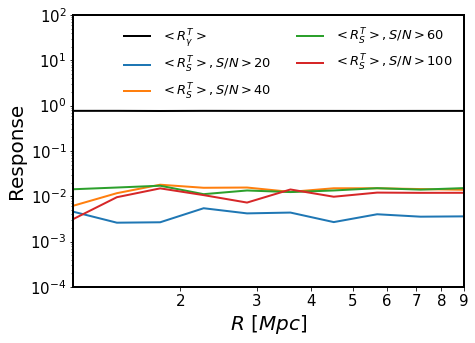

In [12]:
plt.figure(figsize = (7,5))
plt.rcParams['axes.linewidth'] = 2
plt.plot(profile_Metacal['radius'], profile_Metacal['<R_T>'],'-k', linewidth = 2, label = r'$<R_\gamma^T>$')
for s2n in [20, 40, 60, 100]:
    shear.calculate_binned_selection_response(profile = profile_Metacal, uncal_e1 = 'mcal_g1', uncal_e2 = 'mcal_g2', R_s_out = '<R_S>', s2n_cut = s2n)
    plt.plot(profile_Metacal['radius'],  abs(profile_Metacal['<R_S>']), label = f'$<R_S^T>, S/N > {s2n:.0f}$', linewidth = 2)
plt.xscale('log')
plt.yscale('log')
plt.xticks(ticks=[1, 2,3,4, 5,6,7,8,9], labels=['1', '2','3','4','5', '6','7','8', '9'])
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.xlabel(r'$R\ [Mpc]$', fontsize = 20)
plt.ylabel(r'Response', fontsize = 20)
plt.legend(loc='upper right', frameon = False, fontsize = 13, numpoints = 1, ncol = 2)
plt.ylim(1e-4, 100)
plt.xlim(min(profile_Metacal['radius']), max(profile_Metacal['radius']))
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/response', bbox_inches='tight', dpi=300)

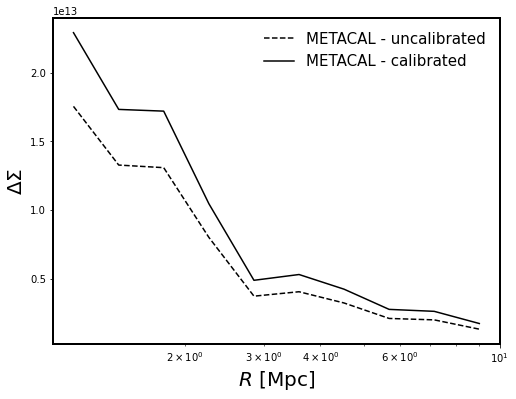

In [13]:
plt.figure(figsize = (8,6))
plt.plot(profile_Metacal['radius'], profile_Metacal['gt'], '--', color = 'k', label = 'METACAL - uncalibrated')
plt.plot(profile_Metacal['radius'], profile_Metacal['gt']/(profile_Metacal['<R_T>']), '-', color = 'k', label = 'METACAL - calibrated')
plt.legend(fontsize = 15, frameon = False)
plt.xlabel(r'$R\ [$' + r'${\rm Mpc}$' + r'$]$', fontsize = 20)
plt.ylabel(r'$\Delta\Sigma$', fontsize = 20)

plt.xscale("log")
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/DeltaSigma_Stacking_mcal.png', bbox_inches='tight', dpi=300)